# <h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria" align="center">Item-Based Sales Forecasting Using Deep Neural Network</h1> 

Dataset: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

**Data fields**

- **date** - Date of the sale data. There are no holiday effects or store closures.
- **store** - Store ID
- **item** - Item ID
- **sales** - Number of items sold at a particular store on a particular date.


In this project, the goal is to forecast 3-month sales for 50 different products in 10 different stores when given 5 years of store item sales data.

# <h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Importing Basic Libraries and Loading Dataset</h1> 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data= pd.read_csv('train.csv', parse_dates = ['date'])
train_data

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
test_data= pd.read_csv('test.csv', parse_dates = ['date'])
test_data

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [4]:
data= pd.concat([train_data, test_data],sort= False)
data

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


# <h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Understanding Dataset</h1> 

In [5]:
data.shape

(958000, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


There are null values, because test data has not sales values and train data has not id values, and no duplicate row:

In [7]:
data.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

In [8]:
data[data.duplicated()]

,date,store,item,sales,id


10 stores and 50 items:

In [9]:
data['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [10]:
data['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

Summary Stats for each store:

In [11]:
data.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                    
       count        sum       mean median        std  min    max
store                                                           
1      91300  4315603.0  47.268379   44.0  24.006252  1.0  155.0
2      91300  6120128.0  67.033165   62.0  33.595810  3.0  231.0
3      91300  5435144.0  59.530602   55.0  29.974102  3.0  196.0
4      91300  5012639.0  54.902946   51.0  27.733097  4.0  186.0
5      91300  3631016.0  39.770164   37.0  20.365757  2.0  130.0
6      91300  3627670.0  39.733516   37.0  20.310451  0.0  134.0
7      91300  3320009.0  36.363735   34.0  18.684825  1.0  122.0
8      91300  5856169.0  64.142048   60.0  32.231751  4.0  204.0
9      91300  5025976.0  55.049025   51.0  27.832186  4.0  195.0
10     91300  5360158.0  58.709288   54.0  29.554994  3.0  187.0

Summary Stats for each item:

In [12]:
data.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                                     
      count        sum       mean median        std   min    max
item                                                            
1     18260   401384.0  21.981599   21.0   8.468922   1.0   59.0
2     18260  1069564.0  58.574151   56.0  20.093015   9.0  150.0
3     18260   669087.0  36.642223   35.0  13.179441   7.0  104.0
4     18260   401907.0  22.010241   21.0   8.403898   0.0   66.0
5     18260   335230.0  18.358708   18.0   7.265167   1.0   50.0
6     18260  1068281.0  58.503888   56.0  20.174898  11.0  148.0
7     18260  1068777.0  58.531051   56.0  20.146002  11.0  141.0
8     18260  1405108.0  76.950055   74.0  26.130697  15.0  181.0
9     18260   938379.0  51.389869   49.5  17.790158   6.0  134.0
10    18260  1337133.0  73.227437   70.0  24.823725  14.0  175.0
11    18260  1271925.0  69.656353   67.0  23.744732  11.0  170.0
12    18260  1271534.0  69.634940   67.0  23.738663  12.0  170.0
13    18260  1539621.0  84.316594   81.0  28.311031  20.0  210.0
14    18260  1071531.0  58.681873   56.0  20.079860  12.0  152.0
15    18260  1607442.0  88.030778   85.0  29.522852  17.0  231.0
16    18260   468480.0  25.656079   25.0   9.603270   2.0   70.0
17    18260   602486.0  32.994852   32.0  11.967610   4.0   83.0
18    18260  1538876.0  84.275794   81.0  28.430621  18.0  208.0
19    18260   736892.0  40.355531   39.0  14.332645   5.0   99.0
20    18260   867641.0  47.515936   46.0  16.490487   9.0  127.0
21    18260   736190.0  40.317087   39.0  14.338006   7.0  109.0
22    18260  1469971.0  80.502245   78.0  27.118163  14.0  214.0
23    18260   534979.0  29.297864   28.0  10.819549   3.0   81.0
24    18260  1205975.0  66.044633   64.0  22.531555  14.0  156.0
25    18260  1473334.0  80.686418   78.0  27.238817  18.0  193.0
26    18260   869981.0  47.644085   46.0  16.723912   8.0  119.0
27    18260   402628.0  22.049726   21.0   8.461641   1.0   59.0
28    18260  1604713.0  87.881325   85.0  29.501781  16.0  206.0
29    18260  1271240.0  69.618839   67.0  23.635631  15.0  173.0
30    18260   736554.0  40.337021   39.0  14.363331   5.0  115.0
31    18260  1070845.0  58.644304   57.0  20.104705  10.0  159.0
32    18260   803107.0  43.981763   42.0  15.574556   5.0  119.0
33    18260  1270183.0  69.560953   67.0  23.718343  15.0  169.0
34    18260   469935.0  25.735761   25.0   9.617910   2.0   79.0
35    18260  1201541.0  65.801807   63.0  22.461990  12.0  168.0
36    18260  1406548.0  77.028916   74.0  26.067440  16.0  188.0
37    18260   534258.0  29.258379   28.0  10.771547   3.0   74.0
38    18260  1470330.0  80.521906   77.0  27.141799  15.0  188.0
39    18260   801311.0  43.883406   42.0  15.511550   7.0  112.0
40    18260   534094.0  29.249398   28.0  10.822959   3.0   74.0
41    18260   401759.0  22.002136   21.0   8.402470   2.0   60.0
42    18260   669925.0  36.688116   35.0  13.215112   5.0   96.0
43    18260   936635.0  51.294359   49.0  17.801008   9.0  126.0
44    18260   536811.0  29.398193   28.0  10.797738   3.0   78.0
45    18260  1471467.0  80.584173   78.0  27.318402  18.0  205.0
46    18260  1070764.0  58.639869   56.0  20.220879  11.0  150.0
47    18260   401781.0  22.003341   21.0   8.420102   2.0   61.0
48    18260   937703.0  51.352848   49.0  17.881917   8.0  130.0
49    18260   535663.0  29.335323   28.0  10.874788   3.0   77.0
50    18260  1203009.0  65.882202   63.0  22.416031  12.0  164.0

Every store has the same number of unique items:

In [13]:
data.groupby(['store'])['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

How many of these items was sold in total in each store?

In [14]:
data.groupby(["store"]).agg({"sales": ["sum"]})

,sales
,sum
store,
1,4315603.0
2,6120128.0
3,5435144.0
4,5012639.0
5,3631016.0
6,3627670.0
7,3320009.0
8,5856169.0


How many of these items were sold in each store?, and other statistics:

In [15]:
data.groupby(['store','item']).agg({'sales':[ 'sum', 'mean', 'median', 'std']})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

# <h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Future Engineering</h1> 

Feature engineering is the process of adding new variables and features to the final dataset used to train a model utilizing historical row data.

**Time Cycles**

There might be some hidden patterns in our dataset that will not be revealed by the regular features.

They are cyclical patterns such as hours of the day, days of the week, months, seasons, etc.

- The most famous one is cosine as it varies between -1 and 1 according to a 0–2π cycle and
- another one is cosine’s brother: sine.

It means that we will create annual cycles.

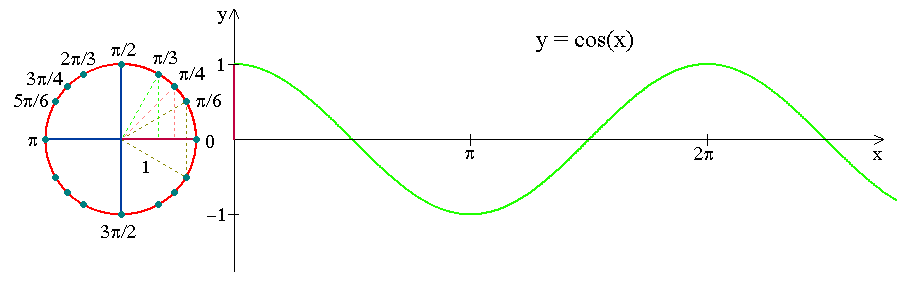

[source](https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca)

Let's reveal it:

Firstly, to reveal it, let's create timed indexes for each item in each store, both for train and test datasets.

In [16]:
train_data.date.nunique()

1826

In [17]:
indexes_train = []

In [18]:
for i in range(train_data.store.nunique()*train_data.item.nunique()):
    indexes_train = np.append(indexes_train, np.linspace(0, train_data.date.nunique()-1, train_data.date.nunique(), dtype=int))
    i=+1
indexes_train

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.823e+03, 1.824e+03,
       1.825e+03])

In [19]:
indexes_train.shape

(913000,)

In [20]:
train_data["indexes"]=indexes_train
train_data

,date,store,item,sales,indexes
0,2013-01-01,1,1,13,0.0
1,2013-01-02,1,1,11,1.0
2,2013-01-03,1,1,14,2.0
3,2013-01-04,1,1,13,3.0
4,2013-01-05,1,1,10,4.0
...,...,...,...,...,...
912995,2017-12-27,10,50,63,1821.0
912996,2017-12-28,10,50,59,1822.0
912997,2017-12-29,10,50,74,1823.0
912998,2017-12-30,10,50,62,1824.0


for test dataset:

In [21]:
indexes_test = []

In [22]:
for i in range(test_data.store.nunique()*test_data.item.nunique()):
    indexes_test = np.append(indexes_test, np.linspace(0, test_data.date.nunique()-1, test_data.date.nunique(), dtype=int))
    i=+1
indexes_test

array([ 0.,  1.,  2., ..., 87., 88., 89.])

In [23]:
indexes_test.shape

(45000,)

In [24]:
test_data["indexes"]=indexes_test
test_data

,id,date,store,item,indexes
0,0,2018-01-01,1,1,0.0
1,1,2018-01-02,1,1,1.0
2,2,2018-01-03,1,1,2.0
3,3,2018-01-04,1,1,3.0
4,4,2018-01-05,1,1,4.0
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,85.0
44996,44996,2018-03-28,10,50,86.0
44997,44997,2018-03-29,10,50,87.0
44998,44998,2018-03-30,10,50,88.0


In [25]:
data= pd.concat([train_data, test_data], sort= False)
data

,date,store,item,sales,indexes,id
0,2013-01-01,1,1,13.0,0.0,NaN
1,2013-01-02,1,1,11.0,1.0,NaN
2,2013-01-03,1,1,14.0,2.0,NaN
3,2013-01-04,1,1,13.0,3.0,NaN
4,2013-01-05,1,1,10.0,4.0,NaN
...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,85.0,44995.0
44996,2018-03-28,10,50,NaN,86.0,44996.0
44997,2018-03-29,10,50,NaN,87.0,44997.0
44998,2018-03-30,10,50,NaN,88.0,44998.0


In [26]:
hour = 60*60 # 1 hour 60*60 seconds...
day  = 24*hour
week = 7*day
year = 365.2425*day

In [27]:
df1=data.copy()

In [28]:
df1["index_second"]= df1["indexes"]*day #seconds difference compared to the first day
df1

,date,store,item,sales,indexes,id,index_second
0,2013-01-01,1,1,13.0,0.0,NaN,0.0
1,2013-01-02,1,1,11.0,1.0,NaN,86400.0
2,2013-01-03,1,1,14.0,2.0,NaN,172800.0
3,2013-01-04,1,1,13.0,3.0,NaN,259200.0
4,2013-01-05,1,1,10.0,4.0,NaN,345600.0
...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,85.0,44995.0,7344000.0
44996,2018-03-28,10,50,NaN,86.0,44996.0,7430400.0
44997,2018-03-29,10,50,NaN,87.0,44997.0,7516800.0
44998,2018-03-30,10,50,NaN,88.0,44998.0,7603200.0


In [29]:
df1["YEAR_index_norm"] = 2 * np.pi * df1["index_second"] / year
df1["YEAR_cos_index"] = np.cos(df1["YEAR_index_norm"])
df1["YEAR_sin_index"] = np.sin(df1["YEAR_index_norm"])
df1

,date,store,item,sales,indexes,id,index_second,YEAR_index_norm,YEAR_cos_index,YEAR_sin_index
0,2013-01-01,1,1,13.0,0.0,NaN,0.0,0.000000,1.000000,0.000000
1,2013-01-02,1,1,11.0,1.0,NaN,86400.0,0.017203,0.999852,0.017202
2,2013-01-03,1,1,14.0,2.0,NaN,172800.0,0.034406,0.999408,0.034399
3,2013-01-04,1,1,13.0,3.0,NaN,259200.0,0.051608,0.998669,0.051585
4,2013-01-05,1,1,10.0,4.0,NaN,345600.0,0.068811,0.997633,0.068757
...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,85.0,44995.0,7344000.0,1.462236,0.108347,0.994113
44996,2018-03-28,10,50,NaN,86.0,44996.0,7430400.0,1.479439,0.091230,0.995830
44997,2018-03-29,10,50,NaN,87.0,44997.0,7516800.0,1.496642,0.074087,0.997252
44998,2018-03-30,10,50,NaN,88.0,44998.0,7603200.0,1.513844,0.056921,0.998379


<AxesSubplot: >

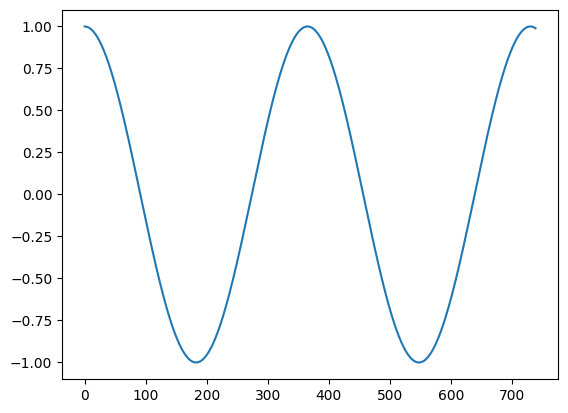

In [30]:
#for example, cos for 2 year for store=1, item=1...
df1.iloc[0:740, 8].plot()

<AxesSubplot: >

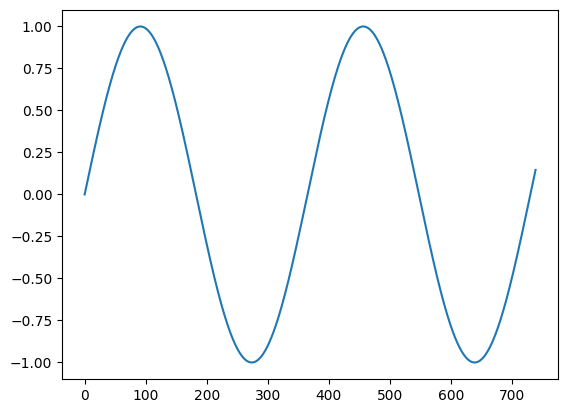

In [31]:
#for example, sin for 2 year for store=1, item=1...
df1.iloc[0:740, 9].plot()

In [32]:
df2 = df1.drop(["indexes","index_second","YEAR_index_norm"], axis=1) #lets remove unnecessary features
df2.head()

,date,store,item,sales,id,YEAR_cos_index,YEAR_sin_index
0,2013-01-01,1,1,13.0,NaN,1.000000,0.000000
1,2013-01-02,1,1,11.0,NaN,0.999852,0.017202
2,2013-01-03,1,1,14.0,NaN,0.999408,0.034399
3,2013-01-04,1,1,13.0,NaN,0.998669,0.051585
4,2013-01-05,1,1,10.0,NaN,0.997633,0.068757


**Date time features**

Date time features are features created from the time stamp value of each observation. Let's create them:

In [33]:
def create_date_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofmonth'] = df.date.dt.day
    df['weekofyear'] = df.date.dt.isocalendar().week.astype("int64")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df

In [34]:
df3 = df2.copy()

In [35]:
df3= create_date_time_features(df3)
df3

,date,store,item,sales,id,YEAR_cos_index,YEAR_sin_index,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
0,2013-01-01,1,1,13.0,NaN,1.000000,0.000000,1,1,1,2013,1,1,1,0
1,2013-01-02,1,1,11.0,NaN,0.999852,0.017202,2,1,1,2013,2,2,1,0
2,2013-01-03,1,1,14.0,NaN,0.999408,0.034399,3,1,1,2013,3,3,1,0
3,2013-01-04,1,1,13.0,NaN,0.998669,0.051585,4,1,1,2013,4,4,1,0
4,2013-01-05,1,1,10.0,NaN,0.997633,0.068757,5,1,1,2013,5,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,0.108347,0.994113,1,1,3,2018,86,27,13,1
44996,2018-03-28,10,50,NaN,44996.0,0.091230,0.995830,2,1,3,2018,87,28,13,1
44997,2018-03-29,10,50,NaN,44997.0,0.074087,0.997252,3,1,3,2018,88,29,13,1
44998,2018-03-30,10,50,NaN,44998.0,0.056921,0.998379,4,1,3,2018,89,30,13,1


**Lag features and window features**

Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future. For example, it can be beneficial to generate features for sales that happened in previous days at 4:00 p.m. if you want to predict similar sales at 4:00 p.m. the next day ([source](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0))

Let's create a function: We will give this function a dataframe, we will create the delays we want as features. It will calculate the 30-day, 60-day, 90-day delay and add it to the dataframe as a new feature in order.

In [36]:
df4= df3.copy()

In [37]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
        df.fillna(0, inplace=True)
    return df

Catching the trend, seasonality, and level is our primary objective.

Since this span of time is three months long, we have added it in multiples of three months, such as three months plus one week, three months plus two weeks, six months, etc.

In [38]:
lag_features(df4, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df4

,date,store,item,sales,id,YEAR_cos_index,YEAR_sin_index,dayofweek,quarter,month,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,0.0,1.000000,0.000000,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-02,1,1,11.0,0.0,0.999852,0.017202,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-03,1,1,14.0,0.0,0.999408,0.034399,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-04,1,1,13.0,0.0,0.998669,0.051585,4,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-05,1,1,10.0,0.0,0.997633,0.068757,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,0.0,44995.0,0.108347,0.994113,1,1,3,...,41.0,54.0,67.0,68.0,68.0,81.0,79.0,60.0,97.0,73.0
44996,2018-03-28,10,50,0.0,44996.0,0.091230,0.995830,2,1,3,...,63.0,51.0,67.0,60.0,76.0,81.0,80.0,73.0,80.0,68.0
44997,2018-03-29,10,50,0.0,44997.0,0.074087,0.997252,3,1,3,...,59.0,63.0,72.0,66.0,73.0,87.0,82.0,68.0,99.0,75.0
44998,2018-03-30,10,50,0.0,44998.0,0.056921,0.998379,4,1,3,...,74.0,75.0,72.0,67.0,66.0,81.0,90.0,69.0,79.0,83.0


**Rolling Mean Features**

The rolling method is used to derive the moving average feature. The window argument also expresses how many steps to go. Average of past 2-3-5 values etc.

When using Rolling method, it gets the previous 2 or 3 or 5 etc. averages including itself. This is problematic. So we need to generate the moving average feature after we get a delay.

In [39]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
        df.fillna(0, inplace=True)
    return df

We will try to reflect information about 1 and 1.5 years ago in the data:

In [40]:
df5= df4.copy()

In [41]:
df5= roll_mean_features(df5, [365, 546])
df5

,date,store,item,sales,id,YEAR_cos_index,YEAR_sin_index,dayofweek,quarter,month,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,0.0,1.000000,0.000000,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2013-01-02,1,1,11.0,0.0,0.999852,0.017202,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2013-01-03,1,1,14.0,0.0,0.999408,0.034399,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,2013-01-04,1,1,13.0,0.0,0.998669,0.051585,4,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2013-01-05,1,1,10.0,0.0,0.997633,0.068757,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,0.0,44995.0,0.108347,0.994113,1,1,3,...,67.0,68.0,68.0,81.0,79.0,60.0,97.0,73.0,78.455254,81.743476
44996,2018-03-28,10,50,0.0,44996.0,0.091230,0.995830,2,1,3,...,67.0,60.0,76.0,81.0,80.0,73.0,80.0,68.0,78.161605,81.674140
44997,2018-03-29,10,50,0.0,44997.0,0.074087,0.997252,3,1,3,...,72.0,66.0,73.0,87.0,82.0,68.0,99.0,75.0,77.865209,81.603658
44998,2018-03-30,10,50,0.0,44998.0,0.056921,0.998379,4,1,3,...,72.0,67.0,66.0,81.0,90.0,69.0,79.0,83.0,77.565828,81.531518


**Exponentially Weighted Mean Features**

This time, we will create features with exponential moving average values corresponding to different alpha values.

In [42]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    dataframe.fillna(0, inplace=True)
    return dataframe

In [43]:
df6= df5.copy()

In [44]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 180, 270, 365, 546, 728]


df6= ewm_features(df6, alphas, lags)

df6.head()

,date,store,item,sales,id,YEAR_cos_index,YEAR_sin_index,dayofweek,quarter,month,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,0.0,1.000000,0.000000,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-02,1,1,11.0,0.0,0.999852,0.017202,2,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-03,1,1,14.0,0.0,0.999408,0.034399,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-04,1,1,13.0,0.0,0.998669,0.051585,4,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-05,1,1,10.0,0.0,0.997633,0.068757,5,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        958000 non-null  float64       
 4   id                           958000 non-null  float64       
 5   YEAR_cos_index               958000 non-null  float64       
 6   YEAR_sin_index               958000 non-null  float64       
 7   dayofweek                    958000 non-null  int64         
 8   quarter                      958000 non-null  int64         
 9   month                        958000 non-null  int64         
 10  year                         958000 non-null  int64         
 11  dayofyear                  

In [46]:
df6.shape

(958000, 72)

# One-Hot-Encoding

In [47]:
df7 = pd.get_dummies(df6, columns=['store', 'item', 'dayofweek', "quarter", 'month', "year", "season"])
df7.shape

(958000, 158)

# Logarithmic Transformation for Sales data

Logarithmic transformation is a convenient means of transforming a skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively

In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model. Overfitting occurs when there are too many dependent variables in play that it does not have enough generalization of the dataset to make a valid prediction. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve.
[source](https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c#:~:text=The%20Why%3A,may%20also%20be%20skewed%20negatively.)

In [48]:
df7['sales']= np.log1p(df7["sales"].values)
df7.head()

,date,sales,id,YEAR_cos_index,YEAR_sin_index,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-02,2.484907,0.0,0.999852,0.017202,2,2,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-03,2.708050,0.0,0.999408,0.034399,3,3,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-04,2.639057,0.0,0.998669,0.051585,4,4,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-05,2.397895,0.0,0.997633,0.068757,5,5,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0


# <h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Splitting Train and Test</h1>

In [49]:
df_model= df7.copy()

In [50]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [51]:
train= df_model.loc[(df_model["date"] <  "2017-01-01"), :]

val=   df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [52]:
train

,date,sales,id,YEAR_cos_index,YEAR_sin_index,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,2.833213,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,3.044522,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-01,3.555348,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-01,2.995732,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730495,2016-12-31,4.060443,0.0,0.999861,-0.016686,366,31,52,75.0,61.0,...,0,0,0,1,0,0,1,0,0,0
730496,2016-12-31,3.610918,0.0,0.999861,-0.016686,366,31,52,48.0,54.0,...,0,0,0,1,0,0,1,0,0,0
730497,2016-12-31,3.367296,0.0,0.999861,-0.016686,366,31,52,44.0,33.0,...,0,0,0,1,0,0,1,0,0,0
730498,2016-12-31,4.025352,0.0,0.999861,-0.016686,366,31,52,59.0,75.0,...,0,0,0,1,0,0,1,0,0,0


In [53]:
val

,date,sales,id,YEAR_cos_index,YEAR_sin_index,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
730500,2017-01-01,3.663562,0.0,1.000000,0.000516,1,1,52,49.0,59.0,...,0,0,0,0,1,0,1,0,0,0
730501,2017-01-01,4.682131,0.0,1.000000,0.000516,1,1,52,131.0,167.0,...,0,0,0,0,1,0,1,0,0,0
730502,2017-01-01,4.077537,0.0,1.000000,0.000516,1,1,52,69.0,84.0,...,0,0,0,0,1,0,1,0,0,0
730503,2017-01-01,3.295837,0.0,1.000000,0.000516,1,1,52,40.0,34.0,...,0,0,0,0,1,0,1,0,0,0
730504,2017-01-01,3.367296,0.0,1.000000,0.000516,1,1,52,38.0,37.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775495,2017-03-31,4.406719,0.0,0.039223,0.999230,90,31,13,55.0,62.0,...,0,0,0,0,1,0,0,1,0,0
775496,2017-03-31,3.555348,0.0,0.039223,0.999230,90,31,13,26.0,24.0,...,0,0,0,0,1,0,0,1,0,0
775497,2017-03-31,3.784190,0.0,0.039223,0.999230,90,31,13,33.0,30.0,...,0,0,0,0,1,0,0,1,0,0
775498,2017-03-31,3.988984,0.0,0.039223,0.999230,90,31,13,38.0,44.0,...,0,0,0,0,1,0,0,1,0,0


In [54]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [55]:
X_train = train[cols]
Y_train = train['sales']

X_val = val[cols]
Y_val = val['sales']

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((730500, 155), (730500,), (45000, 155), (45000,))

# <h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Building and Running Deep Neural Network</h1>

Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras import metrics
import tensorflow as tf

In [57]:
NN_model = Sequential()

NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))#The Input Layer

NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))#The Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))#The Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))#The Hidden Layers

NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))#The Output Layer

#Compile the network
NN_model.compile(loss=tf.keras.losses.mae, optimizer="adam", metrics=['mae'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19968     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 184,833
Trainable params: 184,833
Non-trainable params: 0
_________________________________________________________________


In [58]:
#Define a checkpoint callback :
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [63]:
#Train the model
NN_model.fit(X_train.values, Y_train.values, epochs=2, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/2
18257/18263 [============================>.] - ETA: 0s - loss: 0.1329 - mae: 0.1329
Epoch 1: val_loss did not improve from 0.11890
18263/18263 [==============================] - 127s 7ms/step - loss: 0.1329 - mae: 0.1329 - val_loss: 0.1195 - val_mae: 0.1195
Epoch 2/2
18263/18263 [==============================] - ETA: 0s - loss: 0.1324 - mae: 0.1324
Epoch 2: val_loss did not improve from 0.11890
18263/18263 [==============================] - 130s 7ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.1324 - val_mae: 0.1324


In [64]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

In [65]:
print("VALID SMAPE:", smape(np.expm1(NN_model.predict(X_val).flatten()), np.expm1(Y_val)))

1407/1407 [==============================] - 5s 4ms/step
VALID SMAPE: 13.584441890337414


In [66]:
train_predictions = NN_model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':np.expm1(train_predictions), 'Actuals':np.expm1(Y_train)})
train_results

22829/22829 [==============================] - 83s 4ms/step


,Train Predictions,Actuals
0,11.066269,13.0
1,19.451012,16.0
2,20.796740,20.0
3,31.583412,34.0
4,14.696369,19.0
...,...,...
730495,50.175884,57.0
730496,35.783157,36.0
730497,27.226082,28.0
730498,46.059547,55.0


<a id='test'></a>
<h1 style="background-color:#1E90FF; color:white" style="font-family: Cambria">Test Data Predictions</h1> 

Now, time to test our model on the test dataset. Again splitting data:

In [67]:
df_final_model= df7.copy()
train = df_final_model.loc[(df_final_model["date"] <  "2018-01-01"), :]
Y_train = train['sales']
X_train = train[cols]

test = df_final_model.loc[(df_final_model["date"] >=  "2018-01-01"), :]
X_test = test[cols]

In [68]:
df_final_model

,date,sales,id,YEAR_cos_index,YEAR_sin_index,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,2013-01-01,2.639057,0.0,1.000000,0.000000,1,1,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-02,2.484907,0.0,0.999852,0.017202,2,2,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-03,2.708050,0.0,0.999408,0.034399,3,3,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-04,2.639057,0.0,0.998669,0.051585,4,4,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-05,2.397895,0.0,0.997633,0.068757,5,5,1,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,0.000000,44995.0,0.108347,0.994113,86,27,13,41.0,54.0,...,0,0,0,0,0,1,0,1,0,0
44996,2018-03-28,0.000000,44996.0,0.091230,0.995830,87,28,13,63.0,51.0,...,0,0,0,0,0,1,0,1,0,0
44997,2018-03-29,0.000000,44997.0,0.074087,0.997252,88,29,13,59.0,63.0,...,0,0,0,0,0,1,0,1,0,0
44998,2018-03-30,0.000000,44998.0,0.056921,0.998379,89,30,13,74.0,75.0,...,0,0,0,0,0,1,0,1,0,0


In [69]:
X_train

,YEAR_cos_index,YEAR_sin_index,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,1.000000,0.000000,1,1,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
1,0.999852,0.017202,2,2,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
2,0.999408,0.034399,3,3,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
3,0.998669,0.051585,4,4,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,0.997633,0.068757,5,5,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,0.995982,-0.089549,361,27,52,80.0,72.0,84.0,79.0,79.0,...,0,0,0,0,1,0,1,0,0,0
912996,0.997375,-0.072403,362,28,52,82.0,89.0,90.0,78.0,89.0,...,0,0,0,0,1,0,1,0,0,0
912997,0.998473,-0.055236,363,29,52,90.0,97.0,94.0,97.0,96.0,...,0,0,0,0,1,0,1,0,0,0
912998,0.999276,-0.038052,364,30,52,103.0,97.0,97.0,93.0,92.0,...,0,0,0,0,1,0,1,0,0,0


In [70]:
X_test

,YEAR_cos_index,YEAR_sin_index,dayofyear,dayofmonth,weekofyear,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,season_0,season_1,season_2,season_3
0,1.000000,0.000000,1,1,1,12.0,14.0,22.0,16.0,12.0,...,0,0,0,0,0,1,1,0,0,0
1,0.999852,0.017202,2,2,1,18.0,18.0,21.0,20.0,26.0,...,0,0,0,0,0,1,1,0,0,0
2,0.999408,0.034399,3,3,1,15.0,27.0,20.0,13.0,24.0,...,0,0,0,0,0,1,1,0,0,0
3,0.998669,0.051585,4,4,1,20.0,23.0,20.0,26.0,29.0,...,0,0,0,0,0,1,1,0,0,0
4,0.997633,0.068757,5,5,1,19.0,28.0,28.0,28.0,28.0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,0.108347,0.994113,86,27,13,41.0,54.0,67.0,68.0,68.0,...,0,0,0,0,0,1,0,1,0,0
44996,0.091230,0.995830,87,28,13,63.0,51.0,67.0,60.0,76.0,...,0,0,0,0,0,1,0,1,0,0
44997,0.074087,0.997252,88,29,13,59.0,63.0,72.0,66.0,73.0,...,0,0,0,0,0,1,0,1,0,0
44998,0.056921,0.998379,89,30,13,74.0,75.0,72.0,67.0,66.0,...,0,0,0,0,0,1,0,1,0,0


In [71]:
test_predictions = NN_model.predict(X_test).flatten()

1407/1407 [==============================] - 6s 4ms/step


In [72]:
test_results = pd.DataFrame(data={'Test Predictions':np.expm1(test_predictions)})
test_results

,Test Predictions
0,12.363035
1,15.013029
2,14.991739
3,15.982645
4,17.088366
...,...
44995,65.650810
44996,66.019218
44997,69.416420
44998,72.028107


In [73]:
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_predictions)
submission_df['id'] = submission_df.id.astype(int)
submission_df.head()

,id,sales
0,0,12.363035
1,1,15.013029
2,2,14.991739
3,3,15.982645
4,4,17.088366


In [74]:
submission_df.to_csv('submission.csv', index=False)

<div style="color:white; font-size:125%; text-align:left; display:fill; border-radius:5px; background-color:#1E90FF; overflow:hidden">Thanks for reading. I hope you enjoy it and that it was helpful to you.<br>Please don't forget to follow me and give an upvote on</br>
👇👇👇
</div>

**<a href="https://www.kaggle.com/drindeng/" target="_blank" rel="noopener noreferrer">[Kaggle]</a> | 
<a href="https://github.com/drindeng" target="_blank" rel="noopener noreferrer">[GitHub]</a> |
<a href="https://www.linkedin.com/in/turgay-turker/" target="_blank" rel="noopener noreferrer">[Linkedin]</a>**